## Mod 1 Final Project Submission

* Students' names: Kayli Leung and Alec Morgan
* Students' pace: Full time
* Scheduled project review date/time: 04/19/2019 12:30 PM 
* Instructors' names: Miles Erickson, Greg Damico
* Blog post URL: TODO(Alec): Write blog.

## BUSINESS UNDERSTANDING

## Project Goals

For this project, we imagine ourselves as employees of a company such as Redfin or Zillow. Our goal is to build the most accurate price-estimating model possible, which in turn will help with our site's user retention. To this end we ask three questions:

* How accurately can we predict prices?
* How *consistently* can we maintain that accuracy?
* Can this accuracy be improved by targeting a majority percentile and thus ignoring outliers?

To this end we employ the CRISP-DM methodology: business understanding, data understanding, data preparation, modeling, evaluation, and deployment. 

## Import necessary modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from haversine import haversine

### Loading the King County home sales data set

Here we load our data set: some 21,597 records of home sales in King County, WA from 2014 and 2015. There are 21 pieces of information in each record, each of which is explained briefly in `column_names.md`. A more detailed glossary of these and many more terms can be found at: https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

In [2]:
house_data = pd.read_csv('kc_house_data.csv')

Our dataset is only 2.5 MBs, so we choose not to subsample it (since this step would only be necessary if it were too large to process efficiently in the first place). 

In [3]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


## DATA UNDERSTANDING/PREPARATION

Here we remove and reformat invalid data entries so that we can have data our model is capable of working with. We also choose to remove some data features entirely due to their high collinearities--that is, being similar to each other as well as to the variable we're trying to predict (price). This way we prevent our model from erroneously believing, for example, that `zipcode` and `latitude` count twice when considering a house's value.

In [4]:
house_data['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

454 entries list basement size as `?`. However, these same entries contain `sqft_living` and `sqft_above` values as well, and these often do not match. For columns in which `sqft_basement` is `?`, we reassign `sqft_basement` to `sqft_living` minus `sqft_above`. 

In [5]:
mask = house_data['sqft_basement'] == '?'
house_data.loc[mask, 'sqft_basement'] = (house_data['sqft_living'] - house_data['sqft_above'])
house_data[['sqft_basement', 'sqft_living', 'sqft_above']].head(10).T

,0,1,2,3,4,5,6,7,8,9
sqft_basement,0.0,400.0,0.0,910.0,0.0,1530.0,0,0.0,730.0,0.0
sqft_living,1180,2570,770,1960,1680,5420,1715,1060,1780,1890
sqft_above,1180,2170,770,1050,1680,3890,1715,1060,1050,1890


In [6]:
house_data['view'].isna().sum()

63

We have 63 `NaN` values for `view`. Since this is still not a large proportion of our observations, we choose to discard the afflicted rows. Our total entry count drops from 21,597 to 21,534. 

In [7]:
house_data = house_data.dropna(subset=['view'])
house_data['view'].isna().sum()

0

In [8]:
house_data['yr_renovated'].value_counts().head()

0.0       16961
2014.0       73
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

16,961 of our entries have `yr_renovated` values of `0`. Fixing that would require making unsafe assumptions, so we elect to drop this column entirely instead. 

In [9]:
house_data = house_data.drop('yr_renovated', axis=1)

Time for a quick check on the correlations of our variables!

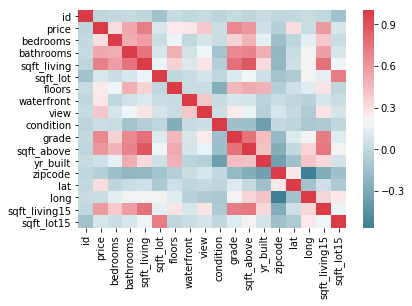

In [10]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
_ = sns.heatmap(house_data.corr(), cmap=color_map)

Due to their high collinearity with other variables, we choose to drop `zipcode`, `sqft_above`, and `sqft_living15`. Furthermore, we dropped `grade` because the documentation of the column showed that part of the grading system includes square footage as well as number of bathrooms, which suggests high collinearity (as reflected in the numbers).

In [11]:
house_data = house_data.drop('zipcode', axis=1)
house_data = house_data.drop('sqft_above', axis=1)
house_data = house_data.drop('sqft_living15', axis=1)
house_data = house_data.drop('grade', axis=1)

In [12]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 16 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       19164 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
sqft_basement    21534 non-null object
yr_built         21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_lot15       21534 non-null int64
dtypes: float64(7), int64(7), object(2)
memory usage: 2.8+ MB


`waterfront` contains 2,370 `Null` values. We don't want to drop 2,370 entries, so we elect to replace these with `0` instead, since `0` is the most frequently occurring value for `waterfront`.

In [13]:
house_data = house_data.fillna(0)

Since `price` is our target variable, we want it to have a normal distribution--if not, it will be difficult to linearly model.

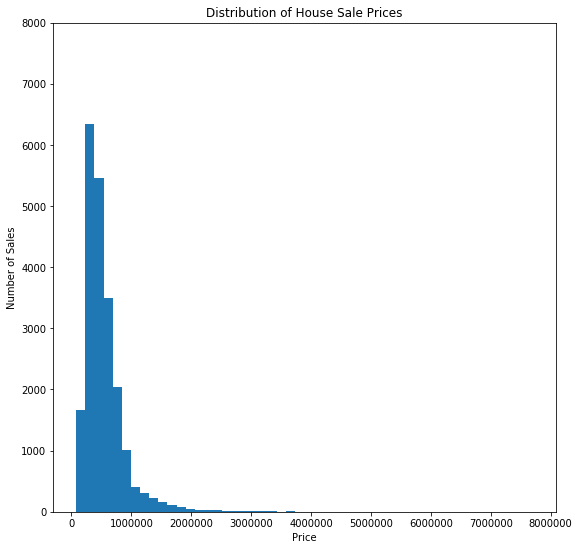

In [59]:
plt.figure(figsize=(9,9))
plt.ylim(0, 8000)
plt.xlabel('Price')
plt.ylabel('Number of Sales')
plt.title('Distribution of House Sale Prices')
_ = plt.hist(house_data['price'], bins=50)

Price is not normally distributed. However, a log transformation will rectify that.

In [15]:
house_data['log_price'] = house_data['price'].apply(lambda x: np.log(x))

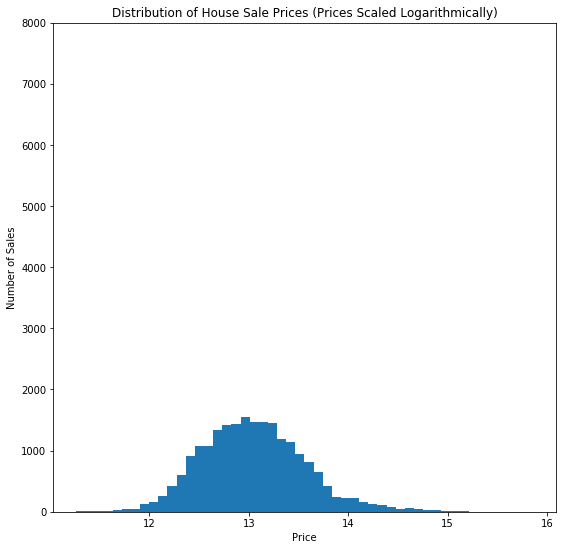

In [16]:
plt.figure(figsize=(9,9))
plt.ylim(0, 8000)
plt.xlabel('Price')
plt.ylabel('Number of Sales')
plt.title('Distribution of House Sale Prices (Prices Scaled Logarithmically)')
_ = plt.hist(house_data['log_price'], bins=50)

Okay, we just scrubbed a lot of data--how do the remaining columns correlate with each other?

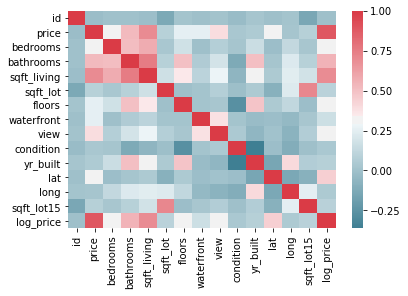

In [17]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
_ = sns.heatmap(house_data.corr(), cmap=color_map)

Most of our highly collinear variables are gone, great! But our strongest remaining predictors (e.g. `bathrooms`, `bedrooms`, and `sqft_living`) still have high collinearity with each other. In spite of this we decide to leave them, and resolve to test our model carefully to get the best accuracy we can without too much overfitting.

At this point, it occurs to us that outliers in price may skew the rest of our predictions. We decide it's in the best interests of our site to predict property values more accurately for the majority of potential users, and to that end we subset our data to the bottom 90th, 95th, and 100th percentiles of price here. Later on we will test our models on all of these, concluding that with the 90th percentile subset we get significantly improved accuracy without noteworthy issues in model bias. 

In [39]:
price_90th_perc = np.percentile(house_data['log_price'], 90)
house_data_90 = house_data.drop(house_data[house_data['log_price'] > price_90th_perc].index)

In [40]:
price_95th_perc = np.percentile(house_data['log_price'], 95)
house_data_95 = house_data.drop(house_data[house_data['log_price'] > price_95th_perc].index)

In [41]:
house_data_100 = house_data

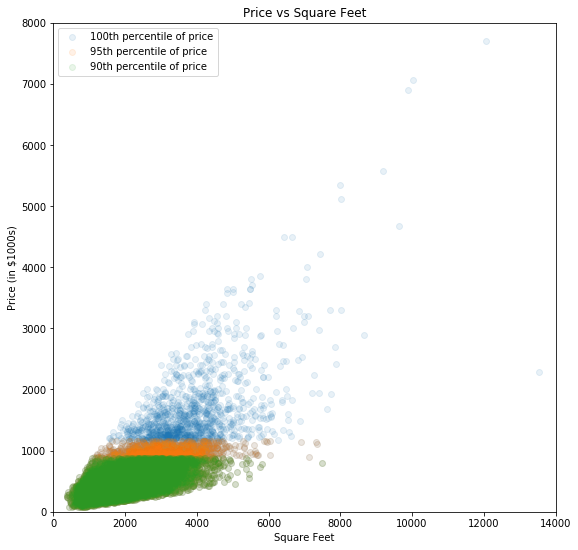

In [63]:
plt.figure(figsize=(9, 9))
plt.title('Price vs Square Feet')
plt.xlim(0, 14000)
plt.ylim(0, 8000)
plt.xlabel('Square Feet')
plt.ylabel('Price (in $1000s)')
_ = plt.scatter(house_data['sqft_living'], house_data['price']/1000, alpha=0.1, label='100th percentile of price')
_ = plt.scatter(house_data_95['sqft_living'], house_data_95['price']/1000, alpha=0.1, label='95th percentile of price')
_ = plt.scatter(house_data_90['sqft_living'], house_data_90['price']/1000, alpha=0.1, label='90th percentile of price')
plt.legend()
plt.show()

## MODELING

Here we proceed to train and test a wide variety of models with a laser focus on our two main goals: accuracy and consistency.

In [ ]:
# get a simple linear regression model for price and sqft_living
x_90 = np.array(house_data_90['sqft_living'])
y_90 = np.array(house_data_90['log_price'])

x_95 = np.array(house_data_95['sqft_living'])
y_95 = np.array(house_data_95['log_price'])

x_100 = np.array(house_data_100['sqft_living'])
y_100 = np.array(house_data_100['log_price'])

In [ ]:
def simple_linear_model(predictor, target, df):
    """Provides model the simple linear regression model between a predictor and target"""
    x = predictor
    y = target
    formula = 'y~x'
    model = ols(formula=formula, data=df).fit()
    return model.summary()

In [ ]:
print(simple_linear_model(x_90, y_90, house_data_90))
print(simple_linear_model(x_95, y_95, house_data_95))
print(simple_linear_model(x_100, y_100, house_data_100))

In [ ]:
def test_median_err(predictors, target):
    """Train a model on the variables provided and return that model's MAE."""
    X = np.array(predictors)
    y = np.array(target)
    linreg = LinearRegression()
    test_err = []
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        linreg.fit(X_train, y_train)
        y_hat_test = linreg.predict(X_test)
        invert_y_hat_test = np.exp(y_hat_test)
        invert_y_test = np.exp(y_test)
        test_err.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        
    return np.mean(test_err)

In [ ]:
sqft_living_mae_90 = test_median_err(x_90.reshape(-1,1), y_90.reshape(-1,1))
sqft_living_mae_95 = test_median_err(x_95.reshape(-1,1), y_95.reshape(-1,1))
sqft_living_mae_100 = test_median_err(x_100.reshape(-1,1), y_100.reshape(-1,1))

sqft_living_mae_90, sqft_living_mae_95, sqft_living_mae_100

After completing an initial model, it is easier to fit to the 90th percentile than to the 95th or 100th percentile of the data. 

In [ ]:
# plt.figure(figsize=(8,8))
# plt.scatter(x_90,y_90, label='scatter', alpha = 0.3)
# plt.plot(x_90, y_hat_90, color='red', label='linear regression')
# plt.title('Square foot of living and their log(prices)')
# plt.legend()
# plt.xlabel('square footage of living space')
# plt.ylabel('log(price)')
# plt.show()

In [ ]:
# Convert date strings to datetime. May work with this later.

In [ ]:
from datetime import datetime

house_data['date'] = pd.to_datetime(house_data['date'])
house_data['date'].sort_values().head()

What follows are our experiments with a preliminary multivariate model.

In [ ]:
outcome = 'log_price'
predictors = house_data.loc[:, ['sqft_living', 'yr_built', 'bedrooms', 'bathrooms', 'view']]
predictors_int = sm.add_constant(predictors)
model = sm.OLS(np.asarray(house_data['log_price']), np.asarray(predictors_int)).fit()

model.summary()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(predictors, house_data['log_price'], test_size=0.3)

In [ ]:
m_linreg = LinearRegression()

m_linreg.fit(X_train, y_train)

In [ ]:
m_linreg.coef_

In [ ]:
m_linreg.intercept_

In [ ]:
y_hat_train = np.exp(m_linreg.predict(X_train))
y_hat_test = np.exp(m_linreg.predict(X_test))

In [ ]:
test_mae = median_absolute_error(y_test,y_hat_test)

print('test: ' + str(test_mae))

In [ ]:
from sklearn.model_selection import cross_val_score

cv_5_results = cross_val_score(m_linreg, predictors, house_data['log_price'], cv=5, scoring='neg_median_absolute_error')

cv_5_results = -1*cv_5_results
cv_5_results

In [ ]:
_ = house_data.hist(figsize=(15,15), bins=30)

Create a column for distance from downtown Seattle (latitude and longitude provide by Google Maps). We expect it to be a useful predictor as Seattle and it's neighboring cities have a large proportion of job opportunities and higher population density.

In [ ]:
downtown_sea = (47.609795, -122.337173) #(lat, lon)

In [ ]:
house_data['lat_long'] = list(zip(house_data['lat'], house_data['long']))
house_data

In [ ]:
house_data['distance_from_downtown_sea'] = house_data['lat_long'].apply(lambda x: haversine(downtown_sea, x, unit='mi'))

In [ ]:
house_data.head()

The dates in this dataframe range from 2014 to 2015. We may want to adjust the price to account for inflation in 2019. $1 in 2014 is the equivalent of $1.07 in 2019.

In [ ]:
house_data['2019_price'] = house_data['price'].apply(lambda x: x*1.07)
house_data.head()

In [ ]:
predictors = house_data.columns
predictors = list(predictors)
predictors.remove('date')
predictors.remove('price')
predictors.remove('log_price')
predictors.remove('lat_long')
predictors.remove('2019_price')
predictors

In [ ]:
predictor_mae = {}
for predictor in predictors:
    x = house_data[[predictor]]
    y = house_data['log_price']
    predictor_mae[predictor] = test_median_err(x,y)

sorted_predictor_mae = sorted(predictor_mae.items(), key=lambda x :x[1])
sorted_predictor_mae

In [ ]:
X1 = house_data[['sqft_living', 'bedrooms', 'bathrooms']]
X2 = house_data[['lat', 'sqft_living']]
y = house_data['log_price']

In [ ]:
test_median_err(X1,y)

In [ ]:
test_median_err(X2,y)

In [ ]:
X3 = house_data[['distance_from_downtown_sea', 'sqft_living']]
test_median_err(X3, y)

In [ ]:
X4 = house_data[['sqft_living', 'lat']]
test_median_err(X4, y)

In [ ]:
X5 = house_data[['sqft_living', 'lat', 'bathrooms']]
test_median_err(X5, y)

In [ ]:
X6 = house_data[['lat', 'bathrooms']]
test_median_err(X6, y)

In [ ]:
X7 = house_data[['sqft_living', 'distance_from_downtown_sea']]
test_median_err(X7, y)

In [ ]:
X8 = house_data[['sqft_living', 'lat']]
test_median_err(X4, y)

In [ ]:
X9 = house_data[['long', 'lat']]
test_median_err(X9, y)

In [ ]:
target = house_data_90['log_price']

for i in range(len(sorted_predictor_mae)):
    predictors = []
    for predictor in sorted_predictor_mae[:i+1]:
        name = predictor[0]
        predictors.append(house_data_90[name]) 
    print(predictors, target)
        #    test_median_err(predictors, target)

In [ ]:
kf = KFold(n_splits=2)
kf.get_n_splits(X3)

In [ ]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    linreg = LinearRegression()
    test_err = []
    linreg.fit(X_train, y_train)
    y_hat_test = linreg.predict(X_test)
    invert_y_hat_test = np.exp(y_hat_test)
    invert_y_test = np.exp(y_test)
    test_err.append(median_absolute_error(invert_y_test, invert_y_hat_test))
        
    print(np.mean(test_err))